In [100]:
#Importing required modules
import numpy as np
import pandas as pd
import pickle
import time
import scipy
import sklearn

import feedparser as fp
import html
from nltk.tokenize import TreebankWordTokenizer,WhitespaceTokenizer,word_tokenize
from gensim.summarization import keywords
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from langdetect import detect
from website.code_bin import Cleaner
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from multiprocessing import Pool
import string
from newspaper import Article

## Models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer


# Plotting
import matplotlib.pyplot as plt

# Comparing the performance of the models

We compare the models in terms of how similar the true pairs are compared to random (average score). We choose a random subset of 10,000 episode descriptions and compare how different models rank the related podcasts. We repeat the experiment many times. further, we find out how the best performing model ranks the related podcast when compared to all podcast episodes.

In [5]:
'''Create a list of hand-picked pairs of related articles and podcast episodes (most podcasts are from 
the Daily podcaast and a few NPR podcasts.)'''

article_urls=['https://news.wbfo.org/post/dark-towers-exposes-chaos-and-corruption-bank-holds-trumps-secrets',
             'https://www.wired.com/insights/2013/11/open-source-a-platform-for-innovation/',
             'https://medium.com/datadriveninvestor/preparing-our-children-for-the-future-a-futurists-education-system-a658b3dc83b9',
             'https://cchange.no/2016/11/the-transformative-role-of-art/',
             'https://www.cnbc.com/2019/12/10/house-democrats-announce-articles-of-impeachment-against-trump.html',
             'https://www.usatoday.com/in-depth/news/nation/2019/12/24/climate-change-how-man-can-save-planet-earth/2614939001/',
             'https://www.nytimes.com/2019/12/09/world/asia/afghanistan-war-documents.html',
             'https://www.nytimes.com/2019/11/08/us/hospitals-lawsuits-medical-debt.html',
             'https://www.cbsnews.com/news/syria-withdrawal-lindsey-graham-blasts-us-withdrawing-troops-northern-syria-posts-2019-10-07/',
             'https://heleo.com/annie-murphy-paul-many-people-fear-math-overcome/8385/',
             'https://observer.com/2019/11/softbank-ceo-masayoshi-son-wework-investments/',
             'https://time.com/5159852/the-surprising-secrets-to-living-longer-and-better/',
             'https://www.gatorcountry.com/swampgas/threads/new-documents-show-how-iran-has-embedded-itself-in-the-politics-of-its-neighbor-iraq-%E2%80%94.463701/',
             'https://www.scientificamerican.com/article/what-s-your-real-motive-for-being-altruistic/',
             'https://www.weforum.org/agenda/2015/12/how-is-big-data-going-to-change-the-world/',
             'https://www.cnn.com/2019/12/06/middleeast/iran-un-protest-deaths-intl/index.html',
              'https://www.nytimes.com/1992/08/23/business/all-about-currency-printers-the-companies-that-make-money-from-making-money.html',
              'https://www.forbes.com/sites/annapowers/2018/04/30/failing-your-way-to-success-why-failure-is-a-crucial-ingredient-for-success/#13ca02896170',
              'https://www.thebalance.com/what-negative-interest-rates-mean-for-investors-1978886',
              'https://www.pbs.org/newshour/show/trump-betrayed-us-fleeing-kurds-condemn-u-s-decision-to-leave-syria',
              'https://www.quora.com/Is-hatred-a-learned-or-innate-emotion',
              'https://www.strategy-business.com/article/What-Happened-after-India-Eliminated-Cash?gko=1fea8',
              'https://www.pbs.org/newshour/science/9-ways-racism-impacts-maternal-health']

In [6]:
episode_urls=['https://podcasts.apple.com/us/podcast/chaos-corruption-trumps-secrets-at-deutsche-bank/id214089682?i=1000466111627',
             'https://podcasts.apple.com/us/podcast/open-source-world/id523121474?i=1000456868976',
             'https://podcasts.apple.com/us/podcast/teaching-for-better-humans/id523121474?i=1000450447574',
             'https://podcasts.apple.com/us/podcast/how-art-changes-us/id523121474?i=1000449599727',
             'https://podcasts.apple.com/us/podcast/democrats-reveal-articles-impeachment-against-president/id1057255460?i=1000459241991',
             'https://podcasts.apple.com/us/podcast/climate-crisis/id523121474?i=1000440827153',
             'https://podcasts.apple.com/us/podcast/a-secret-history-of-the-war-in-afghanistan/id1200361736?i=1000459736917',
             'https://podcasts.apple.com/us/podcast/why-so-many-hospitals-are-suing-their-patients/id1200361736?i=1000458416722',
             'https://podcasts.apple.com/us/podcast/the-story-of-a-kurdish-general/id1200361736?i=1000453427344',
             'https://podcasts.apple.com/us/podcast/dont-fear-math/id523121474?i=1000431804260',
             'https://podcasts.apple.com/us/podcast/943-unicorn-cowboy/id290783428?i=1000452356743',
             'https://podcasts.apple.com/us/podcast/the-fountain-of-youth/id523121474?i=1000411150716',
             'https://podcasts.apple.com/us/podcast/irans-secret-influence-on-iraq/id214089682?i=1000462825992',
             'https://podcasts.apple.com/us/podcast/wired-for-altruism/id523121474?i=1000428430804',
             'https://podcasts.apple.com/us/podcast/big-data-revolution/id523121474?i=1000375100940',
             'https://podcasts.apple.com/us/podcast/a-deadly-crackdown-in-iran/id1200361736?i=1000458531559',
             'https://podcasts.apple.com/us/podcast/371-where-dollar-bills-come-from/id290783428?i=1000448611847',
             'https://podcasts.apple.com/us/podcast/failure-is-an-option/id523121474?i=1000435383251',
             'https://podcasts.apple.com/us/podcast/940-interest-rates-why-so-negative/id290783428?i=1000450549742',
             'https://podcasts.apple.com/us/podcast/is-the-u-s-betraying-its-kurdish-allies/id1200361736?i=1000452754479',
             'https://podcasts.apple.com/us/podcast/why-we-hate/id523121474?i=1000415743915',
             'https://podcasts.apple.com/us/podcast/770-when-indias-cash-disappeared/id290783428?i=1000451220459',
             'https://podcasts.apple.com/us/podcast/the-consequences-of-racism/id523121474?i=1000406499359']

In [7]:
'''Obtain the article titles'''
def generateArticleInput(url,title_only=True):   
    '''This fetches the article information from the URL using the newspaper package.
    title_only flag controls whether embeddings are evaluated on entire article body, or just title.'''
    article = Article(url)
    article.download()
    article.parse()
    
    if(title_only):
        return article.title
    else:
        return article.text
for i in range(len(article_urls)):
    article_titles.append(generateArticleInput(article_urls[i]))

In [ ]:
with open('validation_set.pkl','rb') as fid:
         pickle.dump([descriptions, article_titles],fid) 

## Word2Vec

In [18]:
'''Load embeddings of the episodes dataset'''
floc = '/Users/mohsenghassemi/Desktop/Job_Material/Insight/Project/summaries6/'
with open(floc+'vectorized_summaries0_1580414112.pkl','rb') as fid:
         vecs_df=pickle.load(fid) 

In [19]:
## Put all of the embeddings of the episodes in one list
ep_vecs=[vec[2] for vec in vecs_df]
ep_vecs_first=[item[0] for item in ep_vecs]
all_ep_vecs=[item for sublist in ep_vecs for item in sublist]

## There are a few null values in the embeddings (perhaps after cleaning the description/titles became empty)
all_ep_vecs_clean=np.nan_to_num(np.array(all_ep_vecs))

In [ ]:
similarity_pairs_w2v_all=[]
rank_all=[]
similarity_compare_to_all=[]

for j in range(len(descriptions)):
    start=time.time()
    episode=" ".join([item for item in word_tokenize(clean(descriptions[j])) if item not in stopwords.words('english')])
    article=" ".join([item for item in word_tokenize(clean(article_titles[j])) if item not in stopwords.words('english')])
    vec_ep=ep2vec(word_tokenize(episode)).reshape(1,300)
    vec_ar=ep2vec(word_tokenize(article)).reshape(1,300)
    similarity=sklearn.metrics.pairwise.cosine_similarity(vec_ar,vec_ep)
    similarity_pairs_w2v_all.append(similarity)
    word2vecSimilarity=np.array([sklearn.metrics.pairwise.cosine_similarity
                  (vec_ar.reshape(1,300),i.reshape(1,300)) for i in all_ep_vecs_clean])
    similarity_compare_to_all.append([np.mean(word2vecSimilarity),np.std(word2vecSimilarity),np.max(word2vecSimilarity)])
    rank_all.append(sum(word2vecSimilarity>similarity))
    stop=time.time()
    print(stop-start)

In [30]:
with open('w2v_similarity_all','wb') as fid:
         vecs_df=pickle.dump([rank_all,similarity_compare_to_all,similarity_pairs_w2v_all],fid) 

In [67]:
## Find means and standard deviations to ploit the bar plots

mean_related_w2v=np.mean(similarity_pairs_w2v_all)
stad_related_w2v=np.std(similarity_pairs_w2v_all)
means=[item[0] for item in similarity_compare_to_all]
stds_squared=[item[1]**2 for item in similarity_compare_to_all]
mean_all_w2v=np.mean([means])
std_all_w2v=np.sqrt(np.std(means)**2+np.mean(stds_squared))

Text(0.5, 1.0, 'Word2vec Similarities')

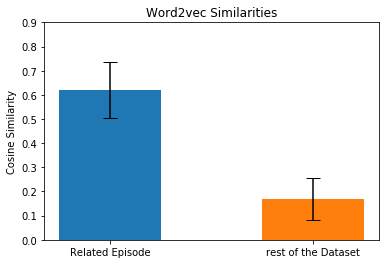

In [69]:
plt.bar('Related Episode', mean_related_w2v, width = .5, capsize=7,yerr=stad_related_w2v, label='poacee')
plt.bar('rest of the Dataset', mean_all_w2v, width = .5, capsize=7,yerr=std_all_w2v, label='poacee')
plt.ylabel('Cosine Similarity')
#plt.legend()
plt.yticks(np.arange(0,1,0.1))
plt.title('Word2vec Similarities')

## GloVe

In [10]:
'''Load embeddings of the episodes dataset'''
floc = '/Users/mohsenghassemi/Desktop/Job_Material/Insight/Project/summaries6/'
with open(floc+'glove_vectors_all_1582566723.pkl','rb') as fid:
         gloves_df=pickle.load(fid) 

In [13]:
## Put all of the embeddings of the episodes in one list
ep_gloves=[vec[2] for vec in gloves_df]
all_ep_gloves=[item for sublist in ep_gloves for item in sublist]

## There are a few null values in the embeddings (perhaps after cleaning the description/titles became empty)
all_ep_vecs_clean=np.nan_to_num(np.array(all_ep_gloves))

In [14]:
similarity_pairs_glove_all=[]
rank_glove_all=[]
similarity_compare_to_glove_all=[]

for j in range(len(descriptions)):
    start=time.time()
    episode=" ".join([item for item in word_tokenize(clean(descriptions[j])) if item not in stopwords.words('english')])
    article=" ".join([item for item in word_tokenize(clean(article_titles[j])) if item not in stopwords.words('english')])
    vec_ep=ep2glove(word_tokenize(episode)).reshape(1,300)
    vec_ar=ep2glove(word_tokenize(article)).reshape(1,300)
    similarity=sklearn.metrics.pairwise.cosine_similarity(vec_ar,vec_ep)
    similarity_pairs_glove_all.append(similarity)
    word2vecSimilarity=np.array([sklearn.metrics.pairwise.cosine_similarity
                  (vec_ar.reshape(1,300),i.reshape(1,300)) for i in all_ep_vecs_clean])
    similarity_compare_to_glove_all.append([np.mean(word2vecSimilarity),np.std(word2vecSimilarity),np.max(word2vecSimilarity)])
    #similarity_compare_to_glove_all.append(word2vecSimilarity)

    rank_glove_all.append(sum(word2vecSimilarity>similarity))
    stop=time.time()
    print(stop-start)

344.86134672164917
292.7602698802948
252.35237669944763
251.42431211471558
305.1134989261627
287.11501002311707
300.5097641944885
269.99775218963623
340.53074407577515
279.8332381248474
287.86505126953125
290.09799885749817
278.1861798763275
324.97962498664856
293.91658186912537
306.154972076416
320.2692680358887
331.23123931884766
308.58899188041687
330.76945066452026
293.1470191478729
316.9494891166687
337.41488790512085


In [15]:
with open('glove_similarity_all','wb') as fid:
         vecs_df=pickle.dump([rank_glove_all,similarity_compare_to_glove_all,similarity_pairs_glove_all],fid) 

In [62]:
## Find means and standard deviations to ploit the bar plots
mean_related_glove=np.mean(similarity_pairs_glove_all)
stad_related_glove=np.std(similarity_pairs_glove_all)
means=[item[0] for item in similarity_compare_to_glove_all]
stds_squared=[item[1]**2 for item in similarity_compare_to_glove_all]
mean_all_glove=np.mean([means])
std_all_glove=np.sqrt(np.std(means)**2+np.mean(stds_squared))

Text(0.5, 1.0, 'GloVe Similarities')

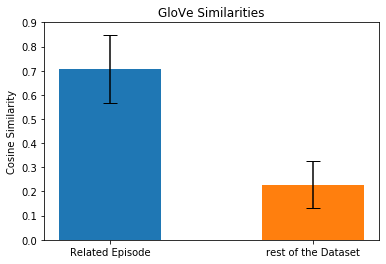

In [65]:
plt.bar('Related Episode', mean_related_glove, width = .5, capsize=7,yerr=stad_related_glove, label='poacee')
plt.bar('rest of the Dataset', mean_all_glove, width = .5, capsize=7,yerr=std_all_glove, label='poacee')
plt.ylabel('Cosine Similarity')
#plt.legend()
plt.yticks(np.arange(0,1,0.1))
plt.title('GloVe Similarities')

## BERT

In [83]:
'''Loading the episodes dataset'''

with open('processed_BERT_sentences_vecs_firstEps_frist4sentence','rb') as fid:
         a=pickle.load(fid)

In [85]:
'''Obtain similarity scores'''

similarity_pairs_BERT=[]
rank_BERT=[]
similarity_compare_to_firsts_BERT=[]

for j in range(len(descriptions)):

    ep_BERT=" ".join([item for item in word_tokenize(clean_BERT(descriptions[j])) if item not in stopwords.words('english')])
    ep_BERT_4='. '.join(ep_BERT.split('. ')[0:4])
    article_bert=" ".join([item for item in word_tokenize(clean_BERT(article_titles[j])) if item not in stopwords.words('english')])
    vec_ep_bert=model_BERT.encode([ep_BERT_4])[0].reshape(1,768)
    vec_ar_bert=model_BERT.encode([article_bert])[0].reshape(1,768)
    similarity=sklearn.metrics.pairwise.cosine_similarity(vec_ep_bert,vec_ar_bert)
    similarity_pairs_BERT.append(similarity)
    bertSimilarity=np.array([sklearn.metrics.pairwise.cosine_similarity
                  (vec_ar_bert, i[0].reshape(1,768)) for i in a['BERT_vecs']])
    similarity_compare_to_firsts_BERT.append([np.mean(bertSimilarity),np.std(bertSimilarity),np.max(bertSimilarity)])
    rank_BERT.append(sum(bertSimilarity>similarity))

In [86]:
with open('BERT_similarity_firsts','wb') as fid:
         pickle.dump([rank_BERT,similarity_compare_to_firsts_BERT,similarity_pairs_BERT],fid) 

In [88]:
## Find means and standard deviations to ploit the bar plots
mean_related_bert=np.mean(similarity_pairs_BERT)
stad_related_bert=np.std(similarity_pairs_BERT)
means=[item[0] for item in similarity_compare_to_firsts_BERT]
stds_squared=[item[1]**2 for item in similarity_compare_to_firsts_BERT]
mean_all_bert=np.mean([means])
std_all_bert=np.sqrt(np.std(means)**2+np.mean(stds_squared))

Text(0.5, 1.0, 'BERT Similarities')

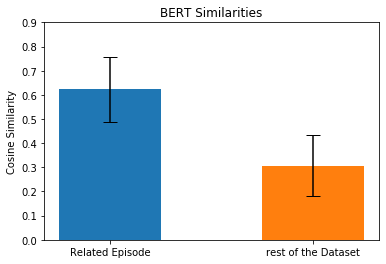

In [89]:
plt.bar('Related Episode', mean_related_bert, width = .5, capsize=7,yerr=stad_related_bert, label='poacee')
plt.bar('rest of the Dataset', mean_all_bert, width = .5, capsize=7,yerr=std_all_bert, label='poacee')
plt.ylabel('Cosine Similarity')
#plt.legend()
plt.yticks(np.arange(0,1,0.1))
plt.title('BERT Similarities')